<a href="https://colab.research.google.com/github/JiviteshG/Colab_Projects/blob/main/Chest_Xray_classification_pneumonia_or_non_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1nrMRjrbeR4PmGtik1hoPOmDleQLvChnq')

In [4]:

!pip install opendatasets --upgrade --quiet

In [5]:

import opendatasets as od

In [6]:

od.download('https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia')

Skipping, found downloaded files in "./chest-xray-pneumonia" (use force=True to force download)


In [7]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
import torchvision
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

import os

In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [9]:

data_dir = "/content/chest-xray-pneumonia/chest_xray"
train_dir = data_dir + "/train/"
val_dir = data_dir + "/val/"
test_dir = data_dir + "/test/"

In [10]:

save_file_name = "vgg16-chest-4.pt"
checkpoint_path = "vgg16-chest-4.pth"

In [11]:

save_file_name = "vgg16-chest-4.pt"
checkpoint_path = "vgg16-chest-4.pth"
#Change to fit hardware
batch_size = 128

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: False


In [12]:
# Empty lists
categories = []
img_categories= []
n_train = []
n_valid = []
n_test = []
heights = []
widths= []

# Iterate through each category
for d in os.listdir(train_dir):
    if not d.startswith('.'):
        categories.append(d)

        # Number of each image
        train_images = os.listdir(train_dir  +  d)
        valid_images = os.listdir(val_dir + d)
        test_images = os.listdir(test_dir + d)

        # Number of datasets
        n_train.append(len(train_images))
        n_valid.append(len(valid_images))
        n_test.append(len(test_images))

        # Find stats for train images
        for i in train_images:
             if not i.startswith('.'):
                img_categories.append(d)
                img = Image.open(train_dir + d + '/' + i)
                img_array = np.array(img)

                # Shape
                heights.append(img_array.shape[0])
                widths.append(img_array.shape[1])

In [13]:

# Dataframe of categories

categories_df = pd.DataFrame({
    "category": categories,

    "n_train": n_train,
    "n_valid": n_valid,
    "n_test": n_test
})

In [14]:

categories_df.sort_values("category")

,category,n_train,n_valid,n_test
1,NORMAL,1341,8,234
0,PNEUMONIA,3875,8,390


In [15]:
# Dataframe of training images

image_df = pd.DataFrame({
    "category": img_categories,
    "height": heights,
    "width": widths
})

In [16]:

categories_df.set_index("category")

,n_train,n_valid,n_test
category,,,
PNEUMONIA,3875,8,390
NORMAL,1341,8,234


In [17]:

categories_df.n_train.count()

np.int64(2)

<Axes: xlabel='category'>

(array([0, 1]), [Text(0, 0, 'PNEUMONIA'), Text(1, 0, 'NORMAL')])

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Training Images by Category')

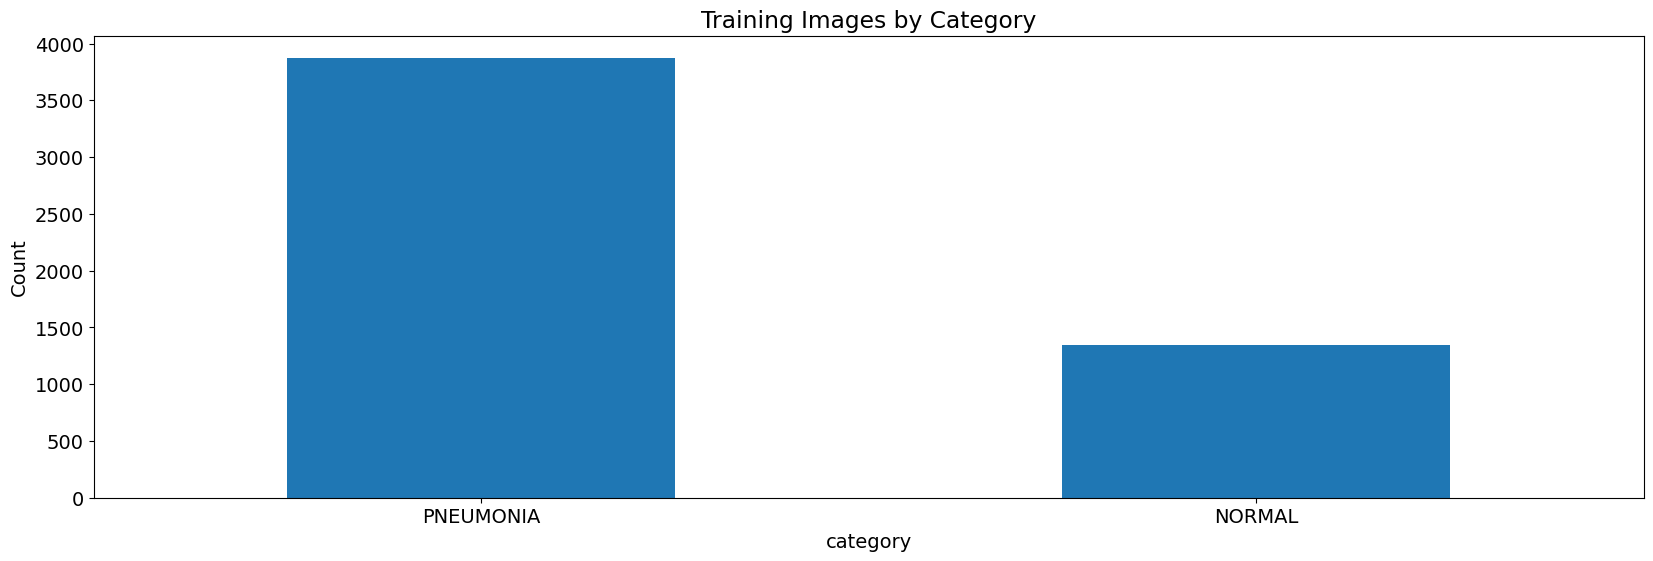

In [18]:
categories_df.set_index('category')['n_train'].plot.bar( figsize=(20, 6))
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Training Images by Category')

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='height', ylabel='Density'>

<Axes: xlabel='height', ylabel='Density'>

Text(0.5, 0, 'Pixels')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'Average Size Distribution')

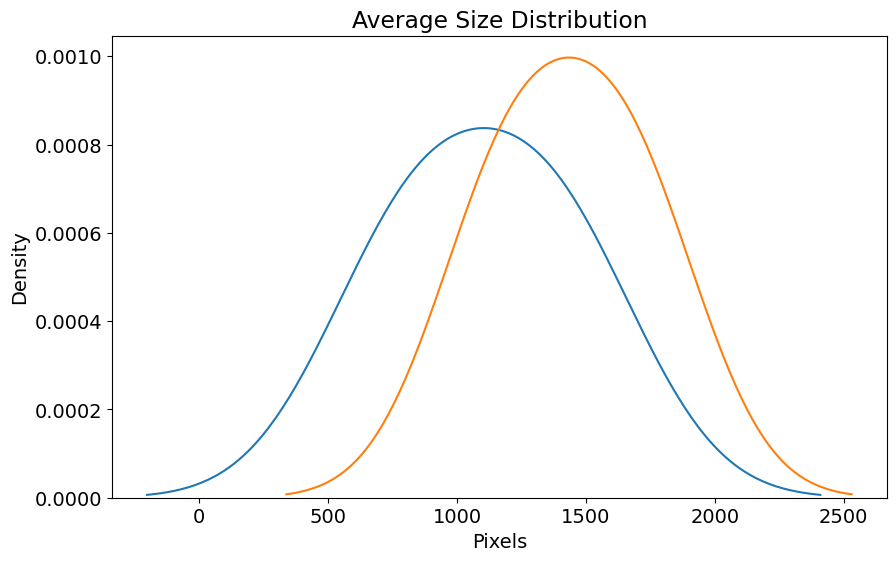

In [19]:

img_dsc = image_df.groupby("category").mean()
plt.figure(figsize=(10,6))

sns.kdeplot(
    img_dsc["height"],
    label="Average Height")

sns.kdeplot(
    img_dsc["width"],
    label="Average Width")

plt.xlabel("Pixels")
plt.ylabel("Density")
plt.title("Average Size Distribution")

In [20]:

def imshow(image):
  plt.figure(figsize=(6,6))
  plt.imshow(image)
  plt.axis("off")
  plt.show()

(1013, 1528)

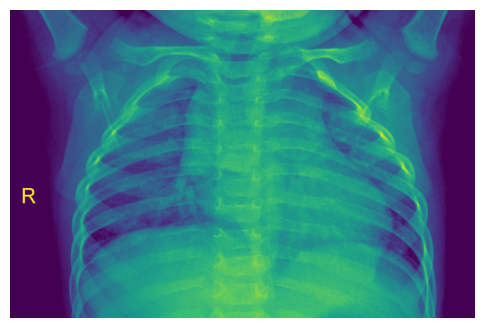

In [21]:

x = Image.open(train_dir + "NORMAL/IM-0128-0001.jpeg")
np.array(x).shape
imshow(x)

(863, 1244)

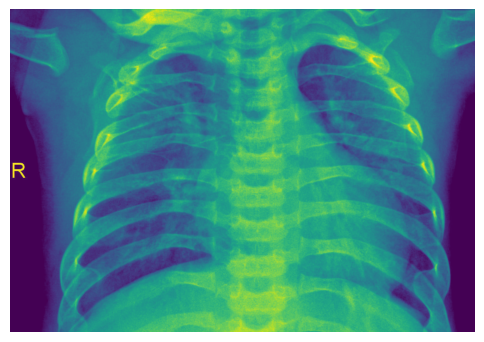

In [22]:

x = Image.open(train_dir + 'PNEUMONIA/person1001_bacteria_2932.jpeg')
np.array(x).shape
imshow(x)

In [23]:

# Data Augmentation for Train Dataset
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size =256, scale= (0.8, 1.0) ),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size =224), # Image net standars
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                                        [0.229, 0.224, 0.225])  # Imagenet standards
    ])

transform_val = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size =224), # Image net standars
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                                        [0.229, 0.224, 0.225])  # Imagenet standards
    ])

transform_test = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size =224), # Image net standars
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                                        [0.229, 0.224, 0.225])  # Imagenet standards
    ])

In [24]:
def imshow_tensor(image, ax=None, title=None):

  if ax is None:
    fig, ax = plt.subplots()

  # Set the color channel as the tird dimension
  image = image.numpy().transpose((1,2,0))

  # Reverse the preprocessing steps
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  image = std * image + mean

  # Clip the image pixel values
  image = np.clip(image, 0, 1)

  ax.imshow(image)
  plt.axis("off")

  return ax, image

In [25]:

train_set = datasets.ImageFolder(train_dir, transform = transform_train)
val_set = datasets.ImageFolder(val_dir, transform = transform_val)
test_set= datasets.ImageFolder(test_dir,transform=transform_test)

In [26]:

# Dataloader iterators
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=True)

In [27]:

train_iter = iter(train_loader)
images, labels = next(train_iter)

print(images.shape)
print(labels.shape)

torch.Size([128, 3, 224, 224])
torch.Size([128])


In [28]:

n_classes = len(categories_df)

print("There are {} different classes.".format(n_classes))

print("Classes in training set: {}".format(train_set.classes))
print("Classes in validation set: {} ".format(val_set.classes))

There are 2 different classes.
Classes in training set: ['NORMAL', 'PNEUMONIA']
Classes in validation set: ['NORMAL', 'PNEUMONIA'] 


In [29]:
def imshow(img, title):
    # Unnormalize (assuming ImageNet stats were used)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    npimg = img.numpy().transpose((1, 2, 0))
    npimg = std * npimg + mean
    npimg = np.clip(npimg, 0, 1)

    plt.figure(figsize=(12, 6))
    plt.axis('off')
    plt.imshow(npimg)
    plt.title(title)
    plt.show()

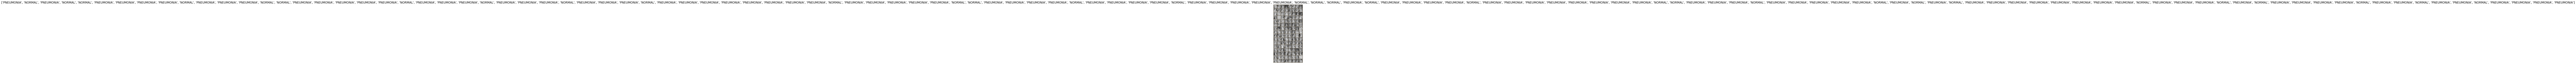

In [30]:
def show_batch_images(data_loader):
    images, labels = next(iter(data_loader))
    img = torchvision.utils.make_grid(images,padding=25)
    imshow(img, title=["NORMAL" if x==0  else "PNEUMONIA" for x in labels])


show_batch_images(train_loader)

Accuracy: 0.5080521472392638
Recall: 0.5080521472392638
Precision: 0.6233299469717103
F1-score: 0.5389724869443867
Confusion Matrix:
[[ 677  664]
 [1902 1973]]


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 31.722222222222207, 'Predicted')

Text(65.72222222222221, 0.5, 'True')

Text(0.5, 1.0, 'Confusion Matrix')

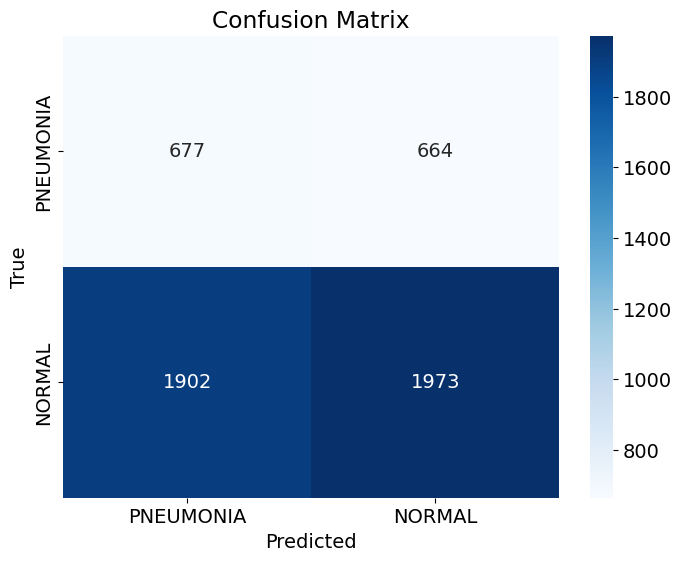

In [31]:
# prompt: print metrics like accuracy recall etc

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# Assuming you have your model's predictions and true labels
# Replace these with your actual predictions and true labels

# Initialize empty lists to store predictions and true labels
y_pred = []
y_true = []

# Loop through the data to get predictions and true labels
# This is just an example, you need to adapt it to your specific model and data loader
for images, labels in train_loader:  # Use your desired data loader (train_loader, val_loader, or test_loader)
    # Get model predictions
    # Example: outputs = model(images)
    # _, predicted = torch.max(outputs, 1)
    # y_pred.extend(predicted.cpu().numpy()) # Assuming 'model' is your trained model

    # Assuming your labels are directly accessible
    y_true.extend(labels.cpu().numpy())

# Example using random predictions for demonstration:
import numpy as np
# Generating random predictions for demonstration purposes - replace with your actual model predictions
y_pred = np.random.randint(0, 2, len(y_true))  # Replace with your actual predictions


# Calculate metrics after collecting predictions and true labels
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')  # Use 'weighted' or other averaging method as needed
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
cm = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1-score: {f1}")
print(f"Confusion Matrix:\n{cm}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories)  # Replace categories with your class names
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [32]:
# prompt: type 1 and type 2 errors

# Type I error (False Positive):
# Predicting a positive result when the true result is negative.
# In the context of the provided code, this would mean classifying an X-ray as "PNEUMONIA" when it's actually "NORMAL".

# Type II error (False Negative):
# Predicting a negative result when the true result is positive.
# In the context of the provided code, this would mean classifying an X-ray as "NORMAL" when it's actually "PNEUMONIA".


# Example of visualizing type I and II errors in the confusion matrix:
# The confusion matrix shows the counts of true positives, true negatives, false positives, and false negatives.
# - False Positives (Type I errors) are in the cells where the predicted label is "PNEUMONIA" but the true label is "NORMAL".
# - False Negatives (Type II errors) are in the cells where the predicted label is "NORMAL" but the true label is "PNEUMONIA".

# To calculate the rates:
# Type I error rate (False Positive Rate) =  False Positives / (False Positives + True Negatives)
# Type II error rate (False Negative Rate) = False Negatives / (False Negatives + True Positives)

# You can access the values from the confusion matrix `cm` to calculate these rates.
fp = cm[0, 1]  # False positives (predicting pneumonia when normal)
tn = cm[0, 0]  # True negatives (correctly predicting normal)
fn = cm[1, 0]  # False negatives (predicting normal when pneumonia)
tp = cm[1, 1]  # True positives (correctly predicting pneumonia)

fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f"False Positive Rate (Type I Error Rate): {fpr}")
print(f"False Negative Rate (Type II Error Rate): {fnr}")


False Positive Rate (Type I Error Rate): 0.49515287099179717
False Negative Rate (Type II Error Rate): 0.4908387096774194
